# CNN Data Preview & Statistics

### Welcome! 

This notebook allows you to preview your single-cell image patches to make sure your annotated data are of good quality. You will also get a chance to calculate the statistics for your annotated data which can be useful for data preprocessing, e.g. *class imbalance check* prior to CNN training.

This notebooks is built on top of our [**CellX** library](github.com/quantumjot/cellx "GitHub || CellX"). Please make sure you have the latest version of the cellx package installed in your environment:

In [1]:
try: 
    import cellx
except:
    !pip3 install -q git+git://github.com/quantumjot/cellx.git

### Import some useful libraries & packages:

In [2]:
import os
import json
import random
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from skimage.io import imread
from typing import List, Union

from cellx.tools.io import read_annotations

### Specify the directory from which you'd like to read your annotated data: 

This path should lead you to the location where your annotation zip files are stored. 

*Default* import directory: `../data/` which contains zip file: `annotation_MM-DD-YYYY--HH-MM-SS.zip`.

In [3]:
root = "../data/"

### Save the figure?

Choose whether you'd like to save out the statistics figure to be visualised below. 

This will be saved in the *default* directory: `../assets/` with file name: `annotation_statistics.png`

In [4]:
save_statistic = False

### Load the annotations = image + labels pairs: 

Read the annotated images and their respective labels & calculate the proportion of un/flagged patches per each class label. 

*Reminder:* 'flagged' image means it was cropped from the edge of the original image so that 0s padding is included in one or more patch edges.

In [5]:
zipfiles_count = len([f for f in os.listdir(root) if f.startswith("annotation") and f.endswith(".zip")])

images_flag, labels_flag, states= read_annotations(path=root, use_flagged=True)
images_pure, labels_pure, _ = read_annotations(path=root, use_flagged=False)

flag = [labels_flag.count(label) for label in states.values()]
pure = [labels_pure.count(label) for label in states.values()]
diff = [f - p for f, p in zip(flag, pure)]


### Specify the colors of the statistics figure:

In [6]:
COLOR_CYCLE = [
    '#1f77b4', # blue
    '#ff7f0e', # orange
    '#2ca02c', # green
    '#d62728', # red
    '#9467bd', # purple
    '#8b4513', # brown
]

### Plot the statistics:

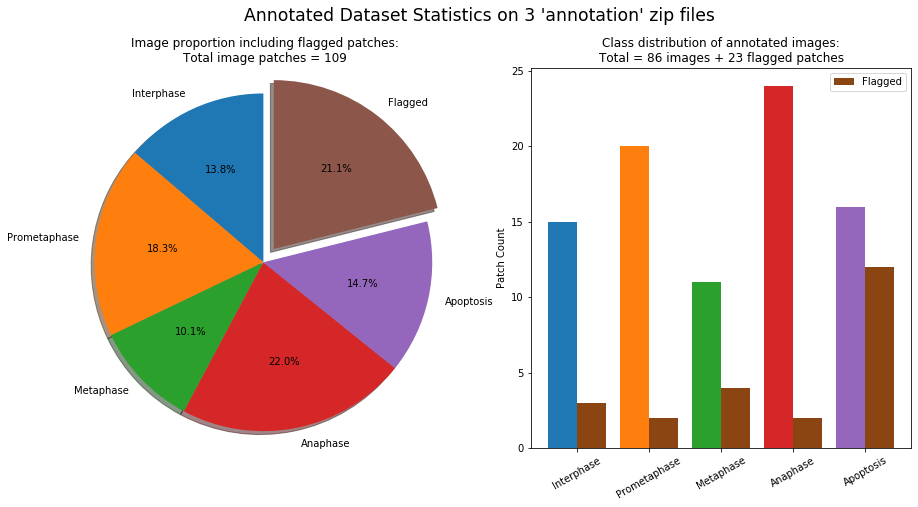

In [100]:
fig, axs = plt.subplots(figsize=(15, 7), nrows=1, ncols=2)
fig.suptitle(x=0.5, y=1.0, t=f"Annotated Dataset Statistics on {zipfiles_count} 'annotation' zip files", fontsize="xx-large")

axs[0].pie(pure + [sum(diff)], explode=[0 for _ in range(len(pure))] + [0.1], 
           labels=list(states.keys()) + ["Flagged"], autopct='%1.1f%%', shadow=True, startangle=90)
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title(f"Image proportion including flagged patches:\nTotal image patches = {len(labels_flag)}")

width = 0.4  # the width of the bars
lbls = list(states.keys())
x = np.arange(len(lbls))  # the label locations

axs[1].bar(x=x - width/2, height=pure, width=width, color=COLOR_CYCLE)
axs[1].bar(x=x + width/2, height=diff, width=width, color=COLOR_CYCLE[-1], label="Flagged")
axs[1].set_xticks(ticks=list(range(len(lbls))))
axs[1].set_xticklabels(labels=lbls, rotation=30)
axs[1].set_title(f"Class distribution of annotated images:\nTotal = {sum(pure)} images + {sum(diff)} flagged patches")
axs[1].set_ylabel(f"Patch Count")

plt.legend()

if save_statistic is True:
    plt.savefig("../assets/annotation_statistics.png", bbox_inches="tight", pad_inches=0)

plt.show()

# Visualise the annotated patches:

First, define a function which will plot the annotated data.

In [7]:
def plot_image_patch_grid(path: Union[str, List[str]], 
                          use_flagged: bool = True, 
                          nrows: int = 5, 
                          ncols: int = 20,
                          save_collage: bool = False):
    
    """ Plot a figure grid (nrows x ncols) with image patches from the 'annotation' dataset."""
    
    images, labels, states = read_annotations(path=path, use_flagged=use_flagged)
    
    # Create a grid of random image patches per class:

    noise_patches = [[np.random.randint(0,255,size=(64,64)).astype(np.uint8) for i in range(nrows * ncols)] for _ in range(len(states))]
    class_patches = [[p for p, l in zip(images, labels) if l == lab] for lab in list(states.values())]

    # Replace in the noise_patches:
    for i in range(len(list(states.values()))):
        noise_patches[i][0:len(class_patches[i])] = class_patches[i]

    # Plot the patches on the grid:
    for i in tqdm(range(len(list(states.keys()))), position=0, leave=True):
        phase = list(states.keys())[i]

        patch_count = len(class_patches[i])
        if patch_count > 100:
            nrows = patch_count // ncols + 1

        fig, axs = plt.subplots(figsize=(ncols, nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
        fig.suptitle(x=0.5, y=1.08, t=f"Annotated Image Patches: {phase}; Total Labelled Patches = {patch_count}", fontsize="xx-large")

        for idx in range(len(noise_patches[i])):

            axs[idx // ncols][idx % ncols].imshow(noise_patches[i][idx], cmap="binary_r")
            axs[idx // ncols][idx % ncols].axis('off')

        plt.tight_layout()

        if save_collage is True:
            plt.savefig(f"../assets/annotation_grid_{phase}.png", bbox_inches="tight", pad_inches=0)

        plt.show()
    

## Choose the annotation zip files which you'd like to visualise:

The `plot_image_patch_grid` function below takes a `path` argument. You have two options to specify the path:

1. `str`     -> The path to the folder containing the annotation.zip files.
2. `list`    -> The list of path(s) to the specific annotation.zip file(s).

You can learn more about the function by typing `help(read_annotations)`.

*Note:* Please allow a few seconds for the figures to be plotted. We experienced about 11 seconds per 5 x 20 patch grid (as shown below). The number of the figures plotted will be equal to the number of the defined labels in your dataset. The red **tqdm** progress bar is provided for the information on the plotting progress.

### 1.) Visualise all image patches, even flagged images, in your dataset:

  0%|          | 0/5 [00:00<?, ?it/s]

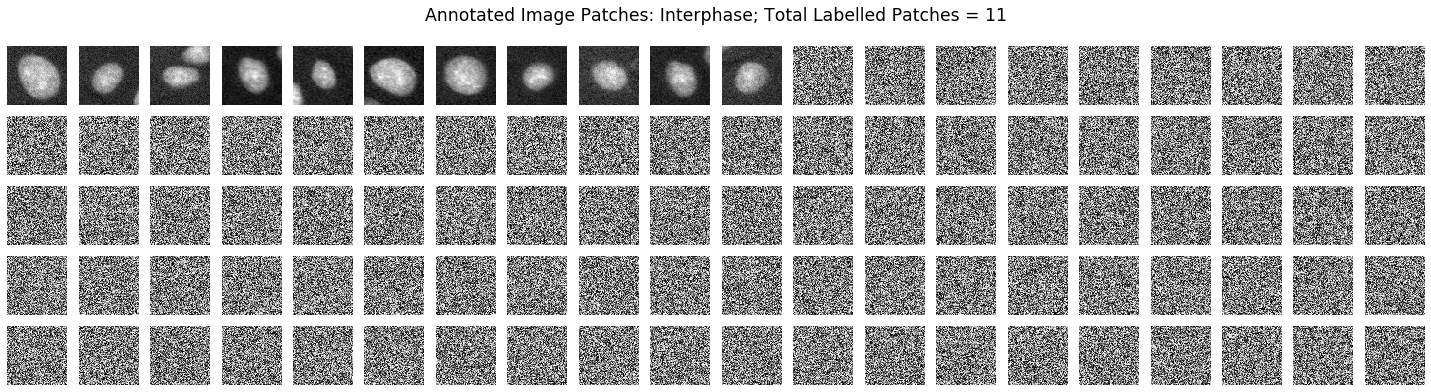

 20%|██        | 1/5 [00:11<00:47, 11.83s/it]

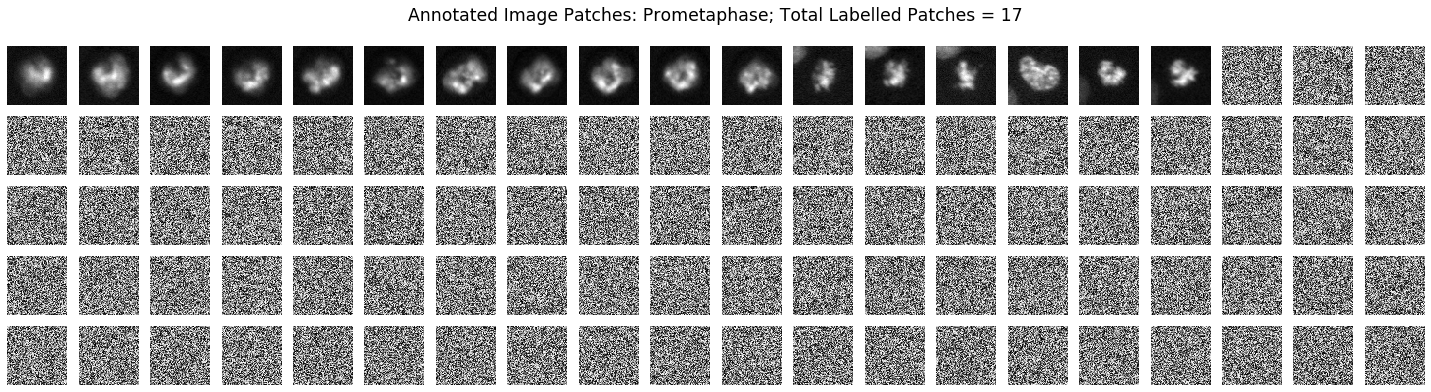

 40%|████      | 2/5 [00:23<00:34, 11.65s/it]

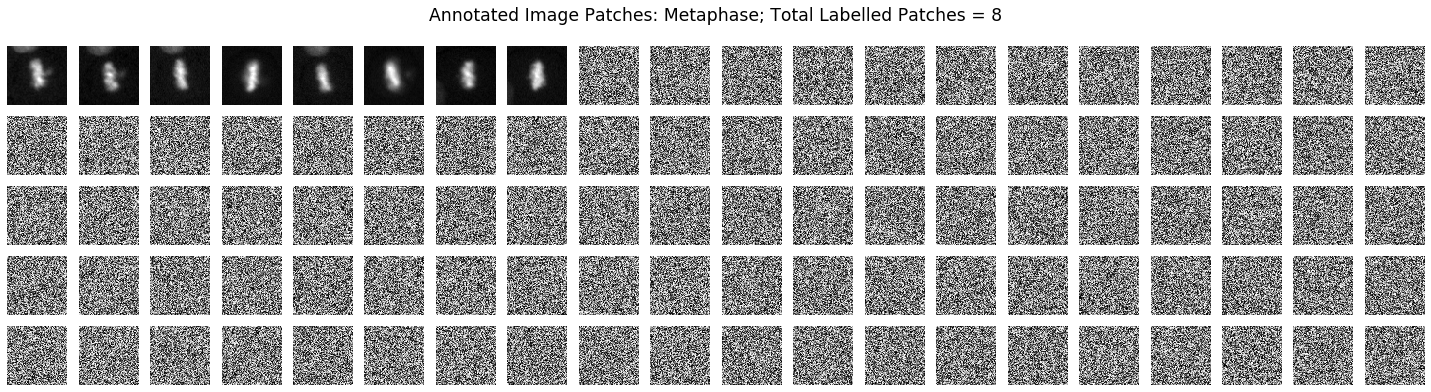

 60%|██████    | 3/5 [00:34<00:22, 11.46s/it]

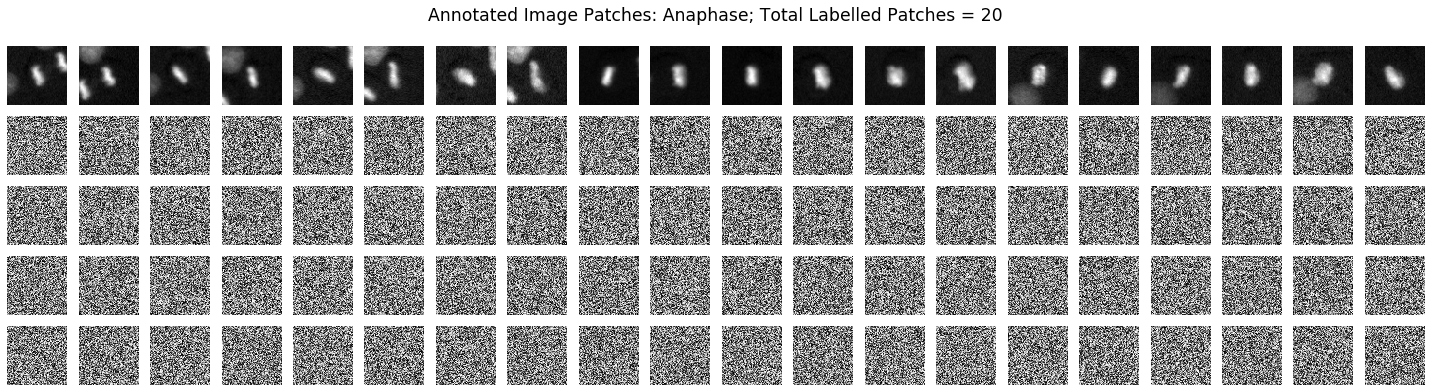

 80%|████████  | 4/5 [00:45<00:11, 11.31s/it]

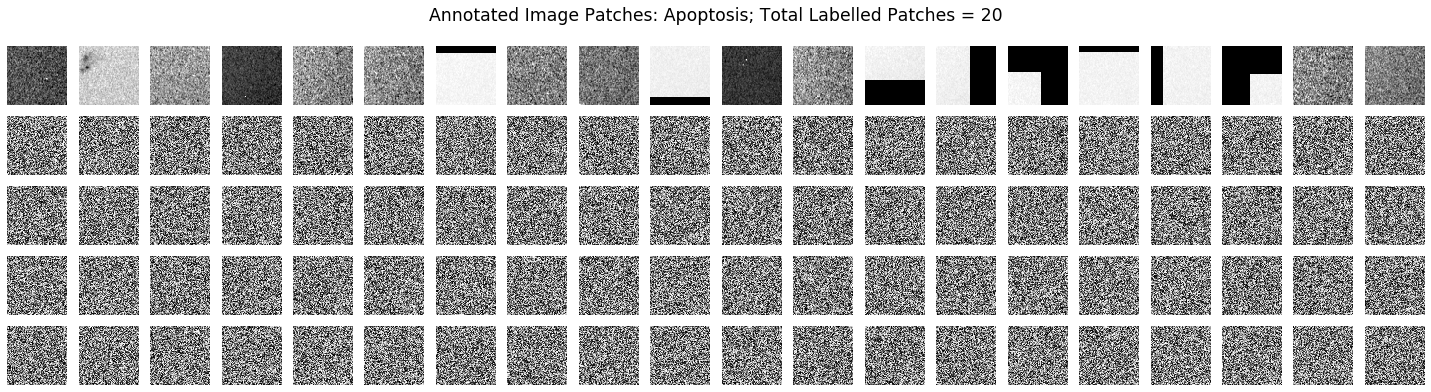

100%|██████████| 5/5 [00:55<00:00, 11.12s/it]


In [8]:
plot_image_patch_grid(path = root, use_flagged = True)

### 2.) Visualise the content of a particular zipfile:

This modality can be particularly useful if you've noticed an error in your labelled dataset, want to explore which annotation files contribute the most to the particular class, or prefer to exclude a file because it contains too many flagged patches.

In any case, you can specify which zip files you'd like to load in the `list` below. Please remember to only specify the name of the file which are present in your `root` directory. 

Let's say you'd only prefer to see how much this particular zip file contributes to the proper (unflagged) image patches - in that case, choose `use_flagged = False`.

*Note:* Please be aware that we only provide one example file in this repository, so the image grid below will seem identical to the grid above. We're hoping you'll make more use of this modality when you collect more annotation zip files on your own data :-) 

In [9]:
specific_zipfiles = ["annotation_03-08-2021--13-39-57.zip"]

In [10]:
zipfiles = [os.path.join(root, fn) for fn in specific_zipfiles]

  0%|          | 0/5 [00:00<?, ?it/s]

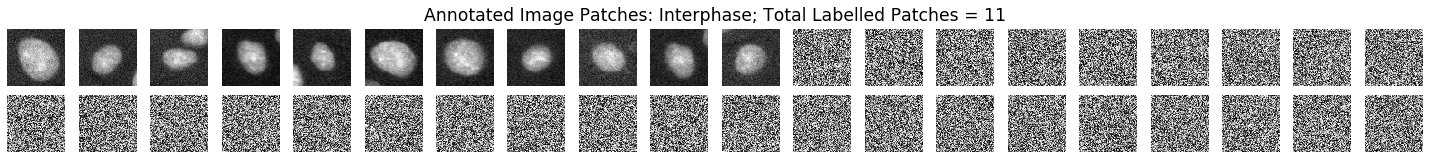

 20%|██        | 1/5 [00:03<00:12,  3.16s/it]

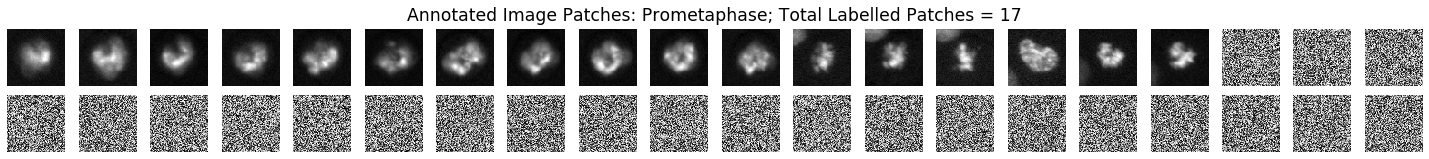

 40%|████      | 2/5 [00:06<00:09,  3.15s/it]

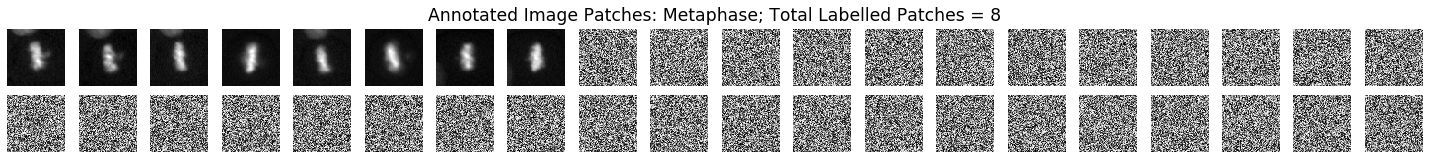

 60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

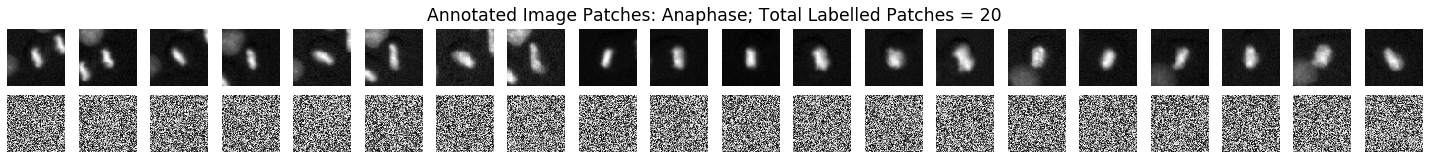

 80%|████████  | 4/5 [00:12<00:03,  3.16s/it]

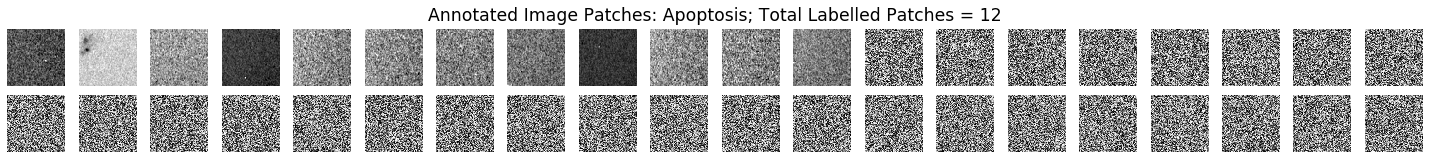

100%|██████████| 5/5 [00:15<00:00,  3.12s/it]


In [11]:
plot_image_patch_grid(path=zipfiles, use_flagged=False, nrows=2)

### Done!